In [244]:
import pandas  as pd
import geopandas as gpd
import sys
import numpy as np
from joblib import Parallel, delayed
import itertools
import matplotlib.pyplot as plt
import time
import os
import warnings
warnings.filterwarnings('ignore')

## Carga de datos 

In [2]:
zones = gpd.read_file('./taxi_zones.shp').to_crs({'init' :'epsg:4326'})
zones['zone'] = zones.zone.astype('category')
zones['borough'] = zones.borough.astype('category')
zones.head()

/home/miguel/anaconda3/envs/geoinformatica/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [3]:
zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [4]:
zones['borough'].unique()

['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn']
Categories (6, object): ['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens', 'Staten Island']

<AxesSubplot:>

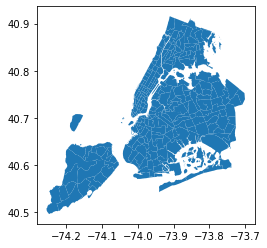

In [5]:
zones.plot()

<AxesSubplot:>

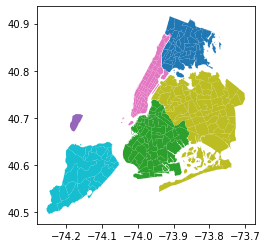

In [6]:
%matplotlib inline
zones.plot(column='borough', categorical=True)

### Datos taxis NY

In [7]:
files = ['yellow_tripdata_2020-01.csv',
         'yellow_tripdata_2020-02.csv',
         'yellow_tripdata_2020-03.csv',
         'yellow_tripdata_2020-04.csv',
         'yellow_tripdata_2020-05.csv',
         'yellow_tripdata_2020-06.csv',
         'yellow_tripdata_2020-07.csv',
         'yellow_tripdata_2020-08.csv', 
         'yellow_tripdata_2020-09.csv',
         'yellow_tripdata_2020-10.csv',
         'yellow_tripdata_2020-11.csv',
         'yellow_tripdata_2020-12.csv'
         
        ] 

In [8]:
taxis_yellow = pd.DataFrame()
for i in files[:8]:
      taxis_yellow= pd.concat([taxis_yellow, pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/'+i )])
    

/home/miguel/anaconda3/envs/geoinformatica/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
taxis_yellow.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
1007279,NaN,2020-08-17 10:44:01,2020-08-17 11:08:05,NaN,9.97,NaN,NaN,87,42,NaN,37.98,0.0,0.5,2.75,0.00,0.3,41.53,0.0
1007280,NaN,2020-08-17 10:32:00,2020-08-17 11:14:00,NaN,16.93,NaN,NaN,209,10,NaN,58.00,0.0,0.5,2.75,0.00,0.3,61.55,0.0
1007281,NaN,2020-08-17 10:30:00,2020-08-17 10:47:00,NaN,2.75,NaN,NaN,215,121,NaN,21.07,0.0,0.5,2.75,0.00,0.3,24.62,0.0
1007282,NaN,2020-08-17 10:21:32,2020-08-17 10:54:42,NaN,10.63,NaN,NaN,212,107,NaN,31.03,0.0,0.5,2.75,6.12,0.3,40.70,0.0
1007283,NaN,2020-08-17 10:38:00,2020-08-17 11:02:00,NaN,8.37,NaN,NaN,213,140,NaN,31.27,0.0,0.5,2.75,0.00,0.3,34.82,0.0


In [10]:
taxis_yellow.reset_index(inplace=True, drop=True)

In [11]:
taxis_yellow.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
18655469,NaN,2020-08-17 10:44:01,2020-08-17 11:08:05,NaN,9.97,NaN,NaN,87,42,NaN,37.98,0.0,0.5,2.75,0.00,0.3,41.53,0.0
18655470,NaN,2020-08-17 10:32:00,2020-08-17 11:14:00,NaN,16.93,NaN,NaN,209,10,NaN,58.00,0.0,0.5,2.75,0.00,0.3,61.55,0.0
18655471,NaN,2020-08-17 10:30:00,2020-08-17 10:47:00,NaN,2.75,NaN,NaN,215,121,NaN,21.07,0.0,0.5,2.75,0.00,0.3,24.62,0.0
18655472,NaN,2020-08-17 10:21:32,2020-08-17 10:54:42,NaN,10.63,NaN,NaN,212,107,NaN,31.03,0.0,0.5,2.75,6.12,0.3,40.70,0.0
18655473,NaN,2020-08-17 10:38:00,2020-08-17 11:02:00,NaN,8.37,NaN,NaN,213,140,NaN,31.27,0.0,0.5,2.75,0.00,0.3,34.82,0.0


In [12]:
taxis_yellow['tpep_pickup_datetime'] =pd.to_datetime(taxis_yellow['tpep_pickup_datetime'])
taxis_yellow['tpep_dropoff_datetime'] =pd.to_datetime(taxis_yellow['tpep_dropoff_datetime'])
taxis_yellow['time_total']= taxis_yellow['tpep_dropoff_datetime']- taxis_yellow['tpep_pickup_datetime'] 


In [13]:
sys.getsizeof(taxis_yellow)

3757616714

Contemos y obtengamos el promedio

In [14]:
%%time
count_or_destino= taxis_yellow[['PULocationID', 'DOLocationID','total_amount' ]].groupby(['PULocationID', 'DOLocationID']).count()

CPU times: user 799 ms, sys: 482 ms, total: 1.28 s
Wall time: 1.28 s


In [15]:
count_or_destino

total_amount
PULocationID DOLocationID              
1            1                     1528
             13                       1
             14                       1
             25                       1
             48                       2
...                                 ...
265          261                      6
             262                      5
             263                      9
             264                    856
             265                   7086

[45240 rows x 1 columns]

In [16]:
count_or_destino.loc[(1,265)]

total_amount    23
Name: (1, 265), dtype: int64

In [17]:
%%time
precio_orig_destino= taxis_yellow[['PULocationID', 'DOLocationID','total_amount' ]].groupby(['PULocationID', 'DOLocationID']).mean()
precio_orig_destino

CPU times: user 529 ms, sys: 157 ms, total: 686 ms
Wall time: 685 ms


total_amount
PULocationID DOLocationID              
1            1                93.154869
             13               76.800000
             14               80.610000
             25               74.800000
             48               83.830000
...                                 ...
265          261              48.755000
             262              33.342000
             263              36.226667
             264             101.442652
             265              84.834948

[45240 rows x 1 columns]

In [18]:
destino = taxis_yellow['PULocationID'].unique()
origen= taxis_yellow['PULocationID'].unique()
dic_l ={} 
for i in destino:
    for j in origen:
        try:
            dic_l[(i,j)]= precio_orig_destino.iloc[(i,j)]
        except:
            dic_l[(i,j)]= 0 
        

In [19]:
#dic_l
zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


Para cada localidad vamos a hacer un mapa de calor donde cada localidad se colorea acorde con el numero de viajes 

In [20]:
count_or_destino.reset_index( inplace=True)

In [21]:
df_1= count_or_destino[count_or_destino['PULocationID' ]==1]

In [22]:
df_1

,PULocationID,DOLocationID,total_amount
0,1,1,1528
1,1,13,1
2,1,14,1
3,1,25,1
4,1,48,2
5,1,50,1
6,1,68,1
7,1,75,1
8,1,89,2
9,1,90,1


In [23]:
type(zones[zones['LocationID']==1]['geometry'].iloc[0])

shapely.geometry.polygon.Polygon

In [24]:
poly= []
for i in df_1['DOLocationID'].apply(lambda l:l):
    poly.append(zones[zones['LocationID']==i]['geometry'])

In [25]:
polygons=[] 
for num,i in enumerate(poly):
    try:
        polygons.append(poly[num][i.index[0]])
    except:
        polygons.append(None)

In [26]:
df_1['geometry']= polygons

/home/miguel/anaconda3/envs/geoinformatica/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_1_g= gpd.GeoDataFrame(df_1)

In [28]:
df_1_g.crs= 'epsg:4326'

In [29]:
df_1_g

,PULocationID,DOLocationID,total_amount,geometry
0,1,1,1528,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,1,13,1,"POLYGON ((-74.01244 40.71906, -74.01282 40.717..."
2,1,14,1,"POLYGON ((-74.03407 40.64431, -74.03284 40.643..."
3,1,25,1,"POLYGON ((-73.98155 40.68915, -73.98102 40.688..."
4,1,48,2,"POLYGON ((-73.99118 40.75533, -73.99163 40.754..."
5,1,50,1,"POLYGON ((-73.99668 40.77351, -73.99434 40.772..."
6,1,68,1,"POLYGON ((-74.00202 40.74044, -74.00252 40.739..."
7,1,75,1,"POLYGON ((-73.94103 40.79255, -73.93865 40.791..."
8,1,89,2,"POLYGON ((-73.95375 40.63859, -73.95360 40.638..."
9,1,90,1,"POLYGON ((-73.99634 40.73804, -73.99684 40.737..."


<AxesSubplot:>

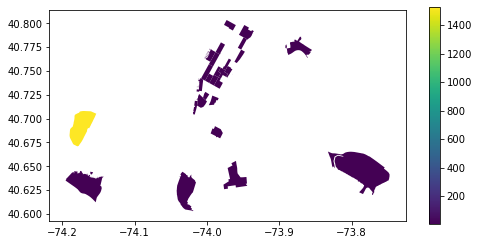

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))
df_1_g.plot(column='total_amount' , ax= axs, legend=True)

In [31]:
#df_1['geometry'] =df_1['DOLocationID'].apply(lambda l: zones[zones['LocationID']==l]['geometry'].iloc[l])

Para parelelizar con Joblib es necesario meter todo dentro de una función. 

In [32]:
def get_hetmap_1(taxis_df, id_loc_pull,  df_poly):
    group_by_count = taxis_df[['PULocationID', 'DOLocationID','total_amount' ]].groupby(['PULocationID', 'DOLocationID']).count()
    group_by_count.reset_index(inplace= True)
    count_id_out= group_by_count[group_by_count['PULocationID' ]==id_loc_pull]
    out_df= count_id_out.merge(right =df_poly[['LocationID' , 'geometry']], how = 'left', left_on='DOLocationID', right_on= 'LocationID' )
    return out_df

In [33]:
%%time
res= get_hetmap_1(taxis_yellow, 2, zones)

CPU times: user 537 ms, sys: 148 ms, total: 686 ms
Wall time: 686 ms


In [39]:
%%time
df_res = Parallel(n_jobs=8,backend='multiprocessing')(delayed(
    get_hetmap_1)(taxis_yellow, i, zones ) for i in zones['LocationID'].unique())

CPU times: user 2min 29s, sys: 25.4 s, total: 2min 54s
Wall time: 2min 58s


In [40]:
%%time
li_lo = []
for i in zones['LocationID'].unique():
    li_lo.append(get_hetmap_1(taxis_yellow, i, zones))

CPU times: user 2min 8s, sys: 37.5 s, total: 2min 46s
Wall time: 2min 46s


In [50]:
df_res= [gpd.GeoDataFrame(i) for i in df_res]

<AxesSubplot:>

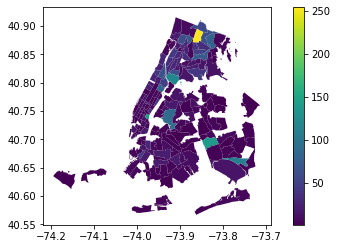

In [61]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

df_res[250].plot(column='total_amount' , ax= axs, legend=True)

Aunque los tiempos resultantes no muestran una reducción en tiempo significativa vemos que es posible trabajar con muchos datos a la vez.

Hagamos una prueba para ver el potencial del uso de la paralelización. 

In [46]:
def function_simple(i, j):
    time.sleep(0.1) 
    return np.sqrt(i**2)+np.sqrt(j**2)

def joblib_comp( function_test,
                n_jobs =2,
               numComps = 30,
                numComps_j = 40, 
               ):
    STime = time.perf_counter()
    executor = Parallel(n_jobs=n_jobs, backend='multiprocessing')
    tasks = (delayed(function_test)(i, j) for i in range(numComps) for j in range(numComps_j))
    compute_task = executor(tasks)
    ETime = time.perf_counter()
    print(f"Joblib finished in {ETime- STime:.2f} secs")

## Numpy code
def numpy_comp(function_test,numComps=30, numComps_j=40 ):
    STime = time.perf_counter()
    srqt_vals = [function_test(i, j) for i in range(numComps) for j in range(numComps_j)]
    # print(srqt_vals)
    ETime = time.perf_counter()
    print(f"Numpy finished in {ETime- STime:.2f} secs")

In [49]:
joblib_comp(function_simple, n_jobs=4)

Joblib finished in 30.61 secs


In [48]:
numpy_comp(function_simple)

Numpy finished in 120.18 secs


In [102]:
pull_lis= [taxis_yellow[taxis_yellow['PULocationID'] == i] for i in  zones['LocationID'].unique()]

In [203]:
def no_voy_para_alla(taxis_df,  df_poly):
    group_by_count = taxis_df[['DOLocationID','total_amount' ]].groupby([ 'DOLocationID']).count()
    group_by_amount = taxis_df[['DOLocationID','total_amount' , 'trip_distance']].groupby(['DOLocationID']).mean()
    group_by_count.reset_index(inplace= True)
    group_by_amount.reset_index(inplace= True)
    out_df = group_by_count.merge(group_by_amount, how= 'left', on = 'DOLocationID')
    #print(id_loc_pull)
    
    if out_df.empty:def no_voy_para_alla(taxis_df,  df_poly):
    group_by_count = taxis_df[['DOLocationID','total_amount' ]].groupby([ 'DOLocationID']).count()
    group_by_amount = taxis_df[['DOLocationID','total_amount' , 'trip_distance']].groupby(['DOLocationID']).mean()
    group_by_count.reset_index(inplace= True)
    group_by_amount.reset_index(inplace= True)
    out_df = group_by_count.merge(group_by_amount, how= 'left', on = 'DOLocationID')
    #print(id_loc_pull)
    
    if out_df.empty:
        
        return pd.DataFrame()
    #print(out_df.iloc[out_df['total_amount_x'].idxmax()]['DOLocationID'])
    out_df['conveniencia'] = out_df.apply(lambda l : (l.total_amount_x*l.total_amount_y)/l.trip_distance, axis= 1)
    out_df= out_df.merge(right =df_poly[['LocationID' , 'geometry']], how = 'right', left_on='DOLocationID', right_on= 'LocationID' )
    return out_df
        
        return pd.DataFrame()
    #print(out_df.iloc[out_df['total_amount_x'].idxmax()]['DOLocationID'])
    out_df['conveniencia'] = out_df.apply(lambda l : (l.total_amount_x*l.total_amount_y)/l.trip_distance, axis= 1)
    out_df= out_df.merge(right =df_poly[['LocationID' , 'geometry']], how = 'right', left_on='DOLocationID', right_on= 'LocationID' )
    return out_df

In [204]:

no_voy_para_alla(pull_lis[0],   zones)

,DOLocationID,total_amount_x,total_amount_y,trip_distance,conveniencia,LocationID,geometry
0,1.0,1528.0,93.154869,0.787834,180673.443417,1,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,NaN,NaN,NaN,NaN,NaN,2,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,NaN,NaN,NaN,NaN,NaN,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,NaN,NaN,NaN,NaN,NaN,4,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,NaN,NaN,NaN,NaN,NaN,5,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,NaN,NaN,NaN,NaN,NaN,259,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,NaN,NaN,NaN,NaN,NaN,260,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,NaN,NaN,NaN,NaN,NaN,261,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,NaN,NaN,NaN,NaN,NaN,262,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [144]:
%%time
df_no_voy = Parallel(n_jobs=8,backend='multiprocessing')(delayed(
    no_voy_para_alla)(i, zones ) for i in pull_lis)

CPU times: user 4.66 s, sys: 1.99 s, total: 6.65 s
Wall time: 5.95 s


In [145]:
%%time
li_lo = []
for i in pull_lis:
    li_lo.append(no_voy_para_alla( i, zones))

CPU times: user 2.5 s, sys: 1e+03 ns, total: 2.5 s
Wall time: 2.5 s


In [113]:
df_no_voy= [gpd.GeoDataFrame(i) for i in df_no_voy] 

In [114]:
df_no_voy[0]

,DOLocationID,total_amount_x,total_amount_y,trip_distance,conveniencia,LocationID,geometry
0,1,1528,93.154869,0.787834,1.806734e+05,1.0,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,13,1,76.800000,13.900000,5.525180e+00,13.0,"POLYGON ((-74.01244 40.71906, -74.01282 40.717..."
2,14,1,80.610000,18.100000,4.453591e+00,14.0,"POLYGON ((-74.03407 40.64431, -74.03284 40.643..."
3,25,1,74.800000,17.250000,4.336232e+00,25.0,"POLYGON ((-73.98155 40.68915, -73.98102 40.688..."
4,48,2,83.830000,16.720000,1.002751e+01,48.0,"POLYGON ((-73.99118 40.75533, -73.99163 40.754..."
5,50,1,90.300000,16.070000,5.619166e+00,50.0,"POLYGON ((-73.99668 40.77351, -73.99434 40.772..."
6,68,1,104.120000,16.190000,6.431130e+00,68.0,"POLYGON ((-74.00202 40.74044, -74.00252 40.739..."
7,75,1,86.800000,23.490000,3.695189e+00,75.0,"POLYGON ((-73.94103 40.79255, -73.93865 40.791..."
8,89,2,96.900000,21.330000,9.085795e+00,89.0,"POLYGON ((-73.95375 40.63859, -73.95360 40.638..."
9,90,1,102.060000,16.020000,6.370787e+00,90.0,"POLYGON ((-73.99634 40.73804, -73.99684 40.737..."


<AxesSubplot:>

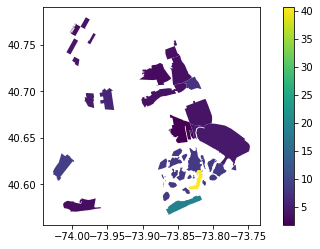

In [117]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))
df_no_voy[1].plot(column='conveniencia' , ax= axs, legend=True)

In [316]:
def no_voy_para_alla_mes(url ,  df_poly):
    """Lee un dataframe y regresa un dataframe con la cuentas de nuestro indice
    """
    lis_lo_mes= []
    taxis_df= pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/'+url )
    for i in df_poly.LocationID.unique():
        taxis_df_te = taxis_df[taxis_df['PULocationID'] == i]
        group_by_count = taxis_df_te[['PULocationID', 'DOLocationID','total_amount' ]].groupby(['PULocationID', 'DOLocationID']).count()
        group_by_amount = taxis_df_te[['PULocationID','DOLocationID','total_amount' , 'trip_distance']].groupby(['PULocationID', 'DOLocationID']).mean()
        group_by_count.reset_index(inplace= True)
        group_by_amount.reset_index(inplace= True)
        out_df = group_by_count.merge(group_by_amount, how= 'left', on = 'DOLocationID')
        if out_df.empty:
            lis_lo_mes.append({'url':url,'Id_pul':i, 'geo_df': pd.DataFrame()})
        else:
            out_df['conveniencia'] = out_df.apply(lambda l : (l.total_amount_x*l.total_amount_y)/l.trip_distance, axis= 1)
            out_df= out_df.merge(right =df_poly[['LocationID' , 'geometry']], how = 'right', left_on='DOLocationID', right_on= 'LocationID' )
            lis_lo_mes.append({'url':url,'Id_pul':i, 'geo_df': out_df})

    return lis_lo_mes

In [206]:
%%time
mes_1= no_voy_para_alla_mes('yellow_tripdata_2020-01.csv', zones)

CPU times: user 16.2 s, sys: 2.59 s, total: 18.8 s
Wall time: 2min 25s


In [1]:
mes_1[2]

NameError: name 'mes_1' is not defined

<AxesSubplot:>

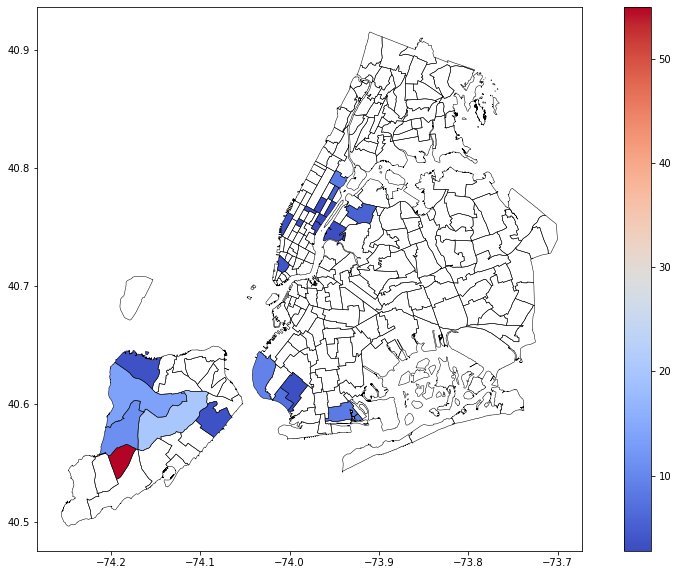

In [225]:
fig, axs = plt.subplots(1, 1, figsize=(15,10))
gpd_plot=gpd.GeoDataFrame(mes_1[4]['geo_df'])
gpd_plot.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=axs) 
gpd_plot.plot(column='conveniencia' , ax= axs, cmap='coolwarm', legend=True)


In [317]:
%%time
year_2020= Parallel(n_jobs=4,backend='multiprocessing')(delayed(
    no_voy_para_alla_mes)(i, zones ) for i in files )

CPU times: user 25 s, sys: 7.93 s, total: 32.9 s
Wall time: 6min 5s


<AxesSubplot:>

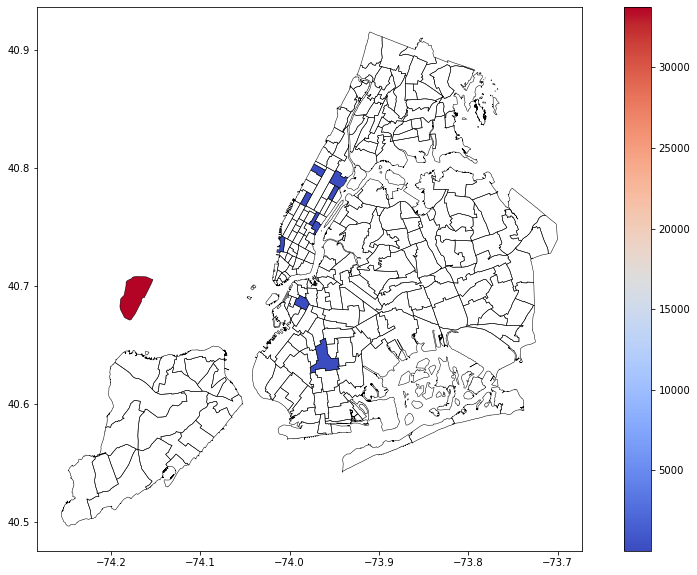

In [255]:

fig, axs = plt.subplots(1, 1, figsize=(15,10))
gpd_plot=gpd.GeoDataFrame(year_2020[2][0]['geo_df'])
gpd_plot.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=axs) 
gpd_plot.plot(column='conveniencia' , ax= axs, cmap='coolwarm', legend=True)


In [283]:
year_2020[1][11]

{'url': 'yellow_tripdata_2020-02.csv',
 'Id_pul': 12,
 'geo_df':      PULocationID_x  DOLocationID  total_amount_x  PULocationID_y  \
 0              12.0           1.0             3.0            12.0   
 1               NaN           NaN             NaN             NaN   
 2               NaN           NaN             NaN             NaN   
 3              12.0           4.0            17.0            12.0   
 4               NaN           NaN             NaN             NaN   
 ..              ...           ...             ...             ...   
 258             NaN           NaN             NaN             NaN   
 259             NaN           NaN             NaN             NaN   
 260            12.0         261.0            56.0            12.0   
 261            12.0         262.0             4.0            12.0   
 262            12.0         263.0             8.0            12.0   
 
      total_amount_y  trip_distance  conveniencia  LocationID  \
 0        100.086667      15.

In [318]:
def image_prod(year_list, id_pull,path):
    print('to save: ' , path+str(id_pull))
    create_dir =path+'/LocaldI_'+str(id_pull) 
    os.mkdir(create_dir)
    geo_df_all=[]
    for i in year_list:
        print(i[id_pull]['Id_pul'])
        pul= i[id_pull]['Id_pul']
        str_i=i[id_pull]['url']
        str_i_s=str_i[str_i.rfind('.')-2:str_i.rfind('.')]
        ### checar si es vacio
        
        if not i[id_pull]['geo_df'].empty:
                        
            geo_df_id= gpd.GeoDataFrame(i[id_pull]['geo_df'])
            fig, axs = plt.subplots(1, 1, figsize=(15,10))
            axs.axis('off')
            geo_df_id.geometry.boundary.plot(color=None,edgecolor='k',linewidth = .5,ax=axs) 
            geo_df_id.plot(column='conveniencia' , ax= axs, cmap='coolwarm', legend=True)
            file_path= create_dir+'/test_pul_'+str(pul)+'_month_'+str_i_s+'.png'
            print('to_save: ',file_path)
            fig.savefig(file_path, dpi=300)

to save:  ./Images1
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_01.png
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_02.png
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_03.png
2
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_05.png
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_06.png
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_07.png
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_08.png
2
to_save:  ./Images/LocaldI_1/test_pul_2_month_09.png
2
2
2


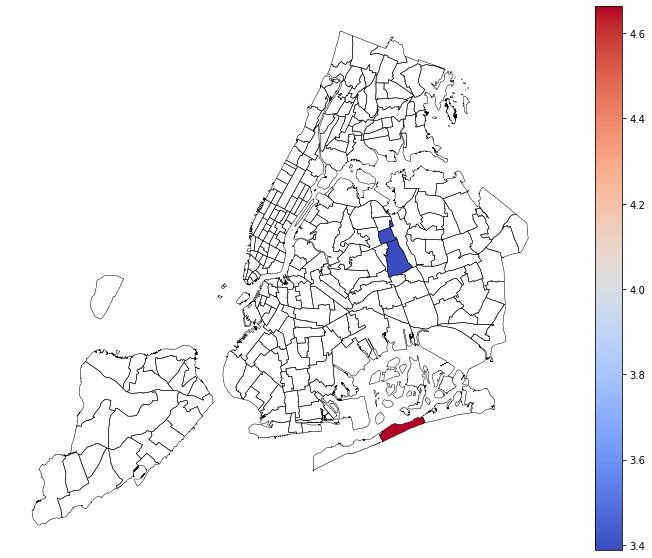

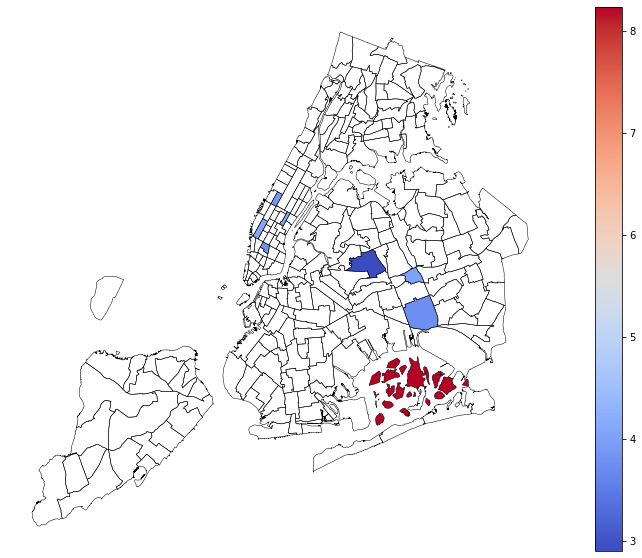

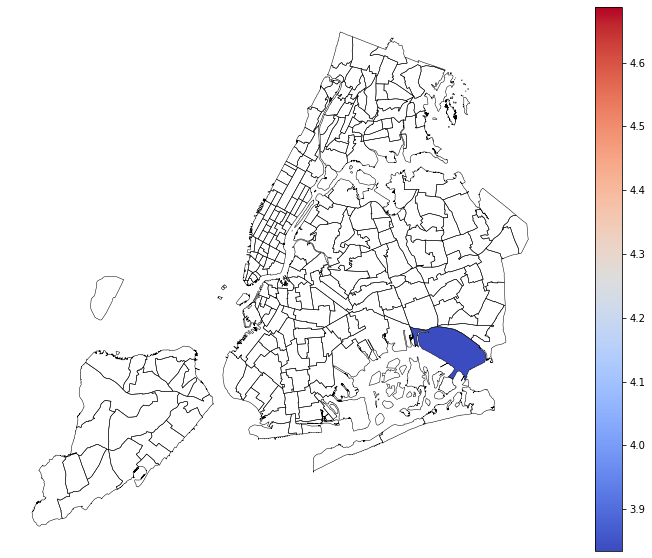

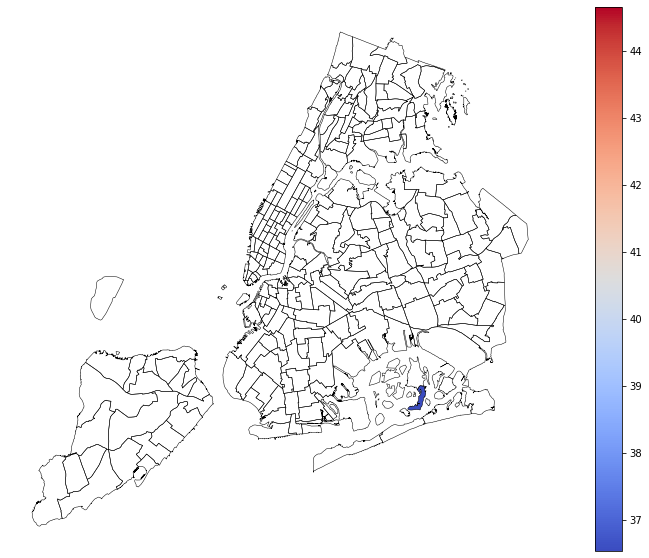

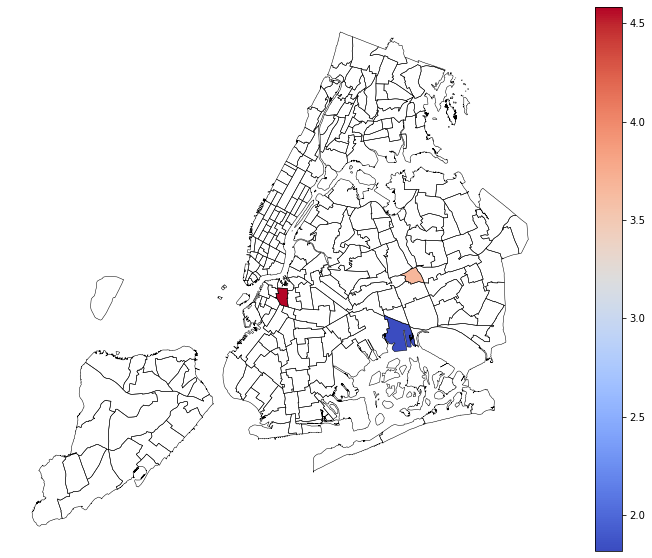

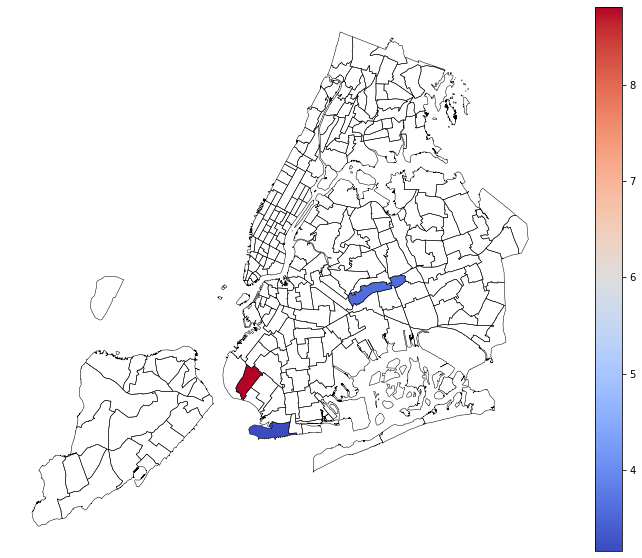

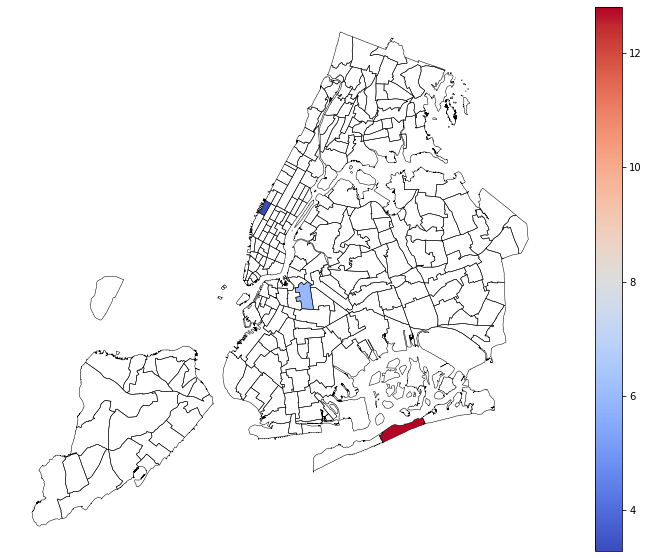

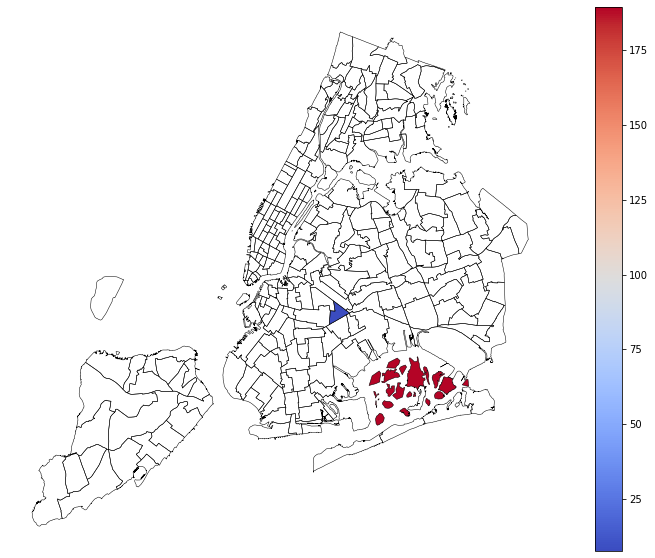

In [319]:

image_prod(year_2020, 1, './Images')